In [92]:
import os
import sys

# Add the path to the parent repository
path = os.path.abspath(os.path.join(os.getcwd(), ".."))
sys_path = set(sys.path) # To avoid inserting many times
if path not in sys_path:
    sys.path.append(path)

In [93]:
from datetime import datetime, time
import json
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd
from pandasql import sqldf
import seaborn as sns
from scripts.trip_management import DatetimesObj, DateTypes, FloatTimes, StrTimes, TripDuration
from scripts.trip_expenses import Budget

<h1 style = "text-align: center; color: #4b8045; font-family: Verdana; font-size: 200%">ANONYMOUS TRANSPORT COMPANY ANALYSIS 🚛</h1>

<p style = "font-family: Verdana">First, I will provide a comprehensive overview of the variables included in our dataset because they are in Spanish:
<ul style = "font-family: Verdana">
    <li> 
    RECEPCIÓN CUENTAS (RECEIPT OF ACCOUNTS): <dd> It shows when the driver delivers his trip-related accounts, such as the signed remission guide, toll road expenses, invoices, and a summary of trip costs. These details are crucial for determining the driver's earnings for the trip they completed, allowing us to calculate the amount they will receive.
    </li>
    <li>
    FECHA (DATE): <dd> The scheduled date of the trip.
    </li>
    <li>
    HORA (HOUR): <dd> The scheduled time for the trip.
    </li>
    <li>
    CLIENTE (CUSTOMER): <dd> It shows who requested the service.
    </li>
    <li>
    MARCA (AUTOMOBILE BRAND): <dd> The brand of the automobile used for the trip.
    </li>
    <li>
    MODELO (AUTOMOBILE MODEL): <dd> The model of the automobile used for the trip.
    </li>
    <li> 
    VIN (CHASIS): <dd> The number of the automobile chassis used for the trip.
    </li>
    <li>
    COLOR: <dd> The color of the automobile used for the trip.
    </li>
    <li>
    FAMILIA (AUTOMOBILE FAMILY): <dd> These can be heavy or light automobiles.
    </li>
    <li>
    ORIGEN (ORIGIN): <dd> The starting point of the trip.
    </li>
    <li>
    DESTINO (DESTINATION) <dd> The destination point of the trip.
    </li> 
    <li>
    PROVEEDOR (SUPPLIER): <dd> Who provides the transportion service in the trip.
    </li>
    <li>
    MOTIVO TRASLADO (REASON FOR THE TRIP): <dd> Why is the reason of the trip?
    </li>
    <li>
    OBSERVACIONES (OBSERVATIONS): <dd> The irregularities in the automobile.
    </li>
    <li> 
    LOCAL / REGIONAL: <dd> The trip was made in Lima or outside the region. 
    </li>
    <li>
    NUEVO / SEMINUEVO (NEW / USED): <dd> The autombile assigned to the trip is new or used.
    </li>
    <li> 
    VOLQUETE (TIPPER TRUCK): <dd> Was a Tipper truck used for the trip?
    </li>
    <li>
    STATUS (STATUS): <dd> The trip status
    </li>
    <li>
    CONDUCTOR (DRIVER): <dd> Who was the driver assigned to the trip?
    </li>
    <li>
    LICENCIA (DRIVER'S LICENSE): <dd> The license number of the driver
    </li>
    <li>
    PLACA (PLATE): <dd> LICENSE PLATE
    </li>
    <li>
    GUIA DE REMISIÓN (REFERRAL GUIDE): <dd> The referral guide number.
    </li>
    <li>
    FECHA DE INICIO (START DATE): <dd> When does the trip start?
    </li>
    <li>
    HORA LLEGADA CONDUCTOR (DRIVER ARRIVAL TIME): <dd> What time did the driver arrive at the meeting point to pick up the automobile?
    </li>
    <li>
    HORA DE INICIO DEL TRANSITO (TRANSIT START TIME): <dd> What time the driver started the trip.
    </li>
    <li>
    FECHA DE LLEGADA (ARRIVAL DATE): <dd> When the driver delivered the automobile in the settled destination.
    </li>
    <li>
    HORA DE LLEGADA DESTINO (ARRIVAL TIME): <dd> The time when the driver delivered the automobile in the final point
    </li>
    <li>
    EMBARQUE (SHIPMENT): <dd> The Shipment ID
    </li>
    <li>
    NRO. TRANSFERENCIA (TRANSFER NUMBER): <dd> The Transfer Number ID
    </li>  
    <li>
    POR RENDIR S/ (BUDGET): <dd> How much money did the driver receive for his expenses during the trip?
    </li>
    <li>
    FECHA TRANSFERENCIA (TRANSFER DATE): <dd> When did the driver receive the money for his expenses?
    </li>
    <li>
    COMBUSTIBLE (FUEL): <dd> How much fuel has it been necessary to deliver during the trip?
    </li>
    <li>
    CINTA REFLECTIVA (REFLECTIVE TAPE): <dd> Was it necessary to put a reflective tape to the automobile?
    </li>
    <li>
    PARACHOQUE (BUMPER): <dd> Was it necessary to implement a bumper to the automobile?
    </li>
    <li>
    HORAS DE ESPERA (WAITING HOURS): <dd> How many hours did the driver wait at the meeting point to pick up the automobile? If the driver waited x hours and this amount > 2, then the waiting hours = x - 2
    </li>
    <li> 
    LAVADO (WASHING): <dd> Was it necessary to wash the automobile for the delivery?
    </li>
    <li>
    REVISIÓN TÉCNICA (TECHNICAL-MECHANICAL REVIEW): <dd> Was it necessary to do a technical-mechanical review for the automobile?
    </li>
    <li>
    OTROS (TRIP DETAILS): <dd> Additional information about the trip.
    </li>
    <li>
    COMENTARIOS (COMMENTS): <dd> Additional information about the trip.
    </li>
    <li>
    INCIDENTES DE TRANSITO / SINIESTROS (TRAFFIC INCIDENTS): <dd> The traffic incident(s) that occurred during the trip.
    </li>
</ul>
</p>
<hr>

In [94]:
#Load the tranport company dataset
df_TransportCompany = pd.read_excel("../data/TRIPS_MADE.xlsx")
#Remove empty spaces in column names
df_TransportCompany.columns = [c.strip() for c in df_TransportCompany.columns]

<h2 style = "font-family: Verdana; font-size: 150%; color: #857c7b">Data Cleaning 🗑️</h1>

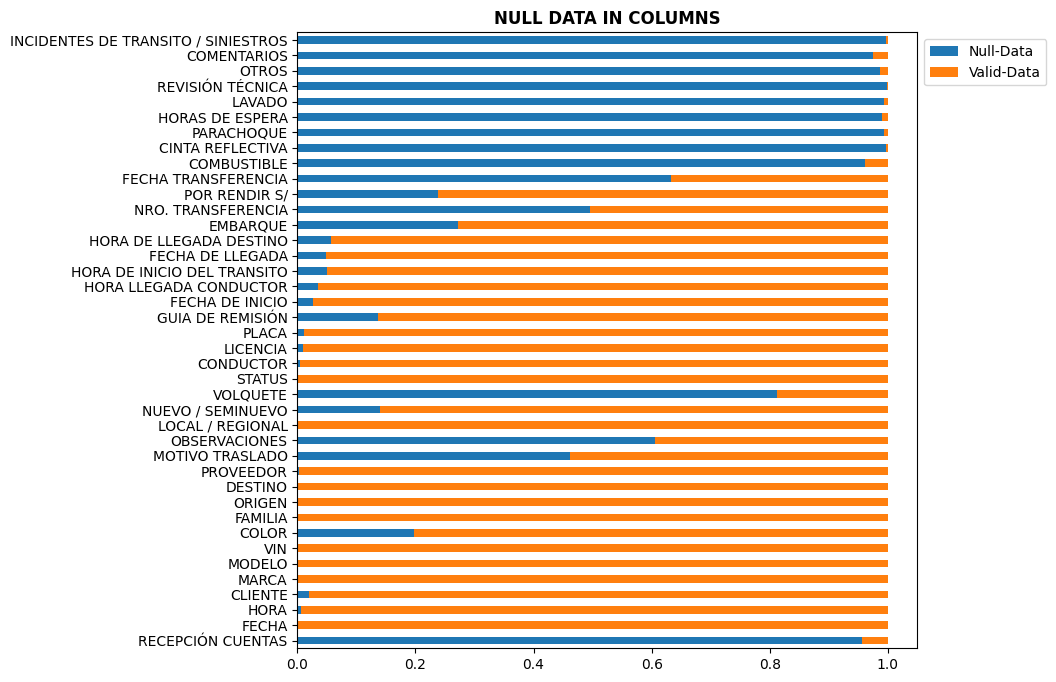

In [95]:
# Let's check the proportion of null data in the df
df_nulldata_columns = pd.DataFrame({
    'Null-Data': df_TransportCompany.isnull().mean(),
})
df_nulldata_columns['Valid-Data'] = 1 - df_nulldata_columns['Null-Data']
# Plot the results
df_nulldata_columns.plot(
    kind = 'barh',
    stacked = True,
    figsize = (8, 8),
)
plt.title('NULL DATA IN COLUMNS', 
          fontdict = {'weight': 'bold'})
plt.legend(bbox_to_anchor = (1, 1))
plt.show()

In [96]:
#Which columns have a high pct of null data (50% <=) ?
(
    ( df_TransportCompany.
     isnull().
     mean() >= 0.5 ).sum() / 
    ( df_TransportCompany.
    shape[1] )
)

np.float64(0.325)

<p style = "font-family: Verdana">It's normal to see various columns with a large amount of null data, because there were trips where it was not necessary to put a reflective tape or a bumper, refuel the car, do the Technical-Mechanical Review, etc. So we have to fill these null data with Missing values.</p>

<p style = "font-family: Verdana">
Another point to mention is that we can see at a glance that there are no trips with all null data in all columns. But, let's check if what I say is true.
</p>

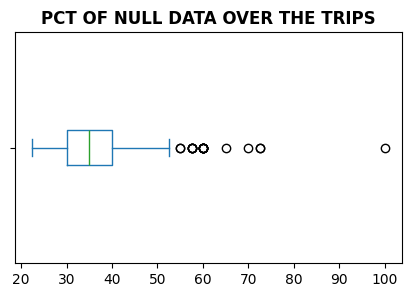

In [97]:
#What is the median of the null attributes in each trip 
(
    ( (df_TransportCompany.
    isnull().
    mean(axis = 1)) * 100 ).
    plot(
        kind = 'box',
        vert = False,
        figsize = (5, 3)
    )
)
plt.title('PCT OF NULL DATA OVER THE TRIPS', 
          fontdict={'weight': 'bold'})
plt.show()

<p style = "font-family: Verdana">We can see a significant proportion of trips that have a high pct of null data over their attributes. And as I mentioned before, it can be a good explanation that in the vast majority of the trips it was not necessary to implement anything extra (bumper, reflective tape, fuel) on the car and there were no incidents with it.</p>

In [98]:
null_trips = df_TransportCompany.loc[
    ( df_TransportCompany.
     isnull().
     mean(axis = 1) ) == 1
].index
df_TransportCompany.drop(null_trips,
                         axis = 0,
                         inplace = True)
print(f'{ len(null_trips) } trip(s) with only null data over its columns')

1 trip(s) with only null data over its columns


In [99]:
# Let's fill in the null data of the columns related to the extra costs in a trip.
trip_extra_costs = ['COMBUSTIBLE', 'CINTA REFLECTIVA', 'PARACHOQUE', 
                    'OBSERVACIONES', 'LAVADO', 'REVISIÓN TÉCNICA', 
                    'OTROS', 'COMENTARIOS', 'INCIDENTES DE TRANSITO / SINIESTROS']

for extra_cost in trip_extra_costs:
    df_TransportCompany.loc[:, extra_cost] = df_TransportCompany.loc[:, extra_cost].fillna('Missing')
    
# Assign new values to the VOLQUETE column
df_TransportCompany['VOLQUETE'] = np.where(df_TransportCompany['VOLQUETE'] == 'SI', '1', 
                                           np.where(df_TransportCompany['VOLQUETE'] == 'NO','0', 'NOT SPECIFIED'))                                        

# Since the np.where returns an homogeneus array (i.e the same dtype for all values)
cond_number = df_TransportCompany['VOLQUETE'].str.isdecimal() # Condition to get the 1's and 0's values

df_TransportCompany.loc[
    cond_number, 'VOLQUETE'
] = df_TransportCompany.loc[cond_number, 'VOLQUETE'].astype(int)

<p style = "font-family: Verdana"> Well, I fill all the columns that don't necessary to have a validate value in the trip. </p> 

In [100]:
df_TransportCompany['VOLQUETE'].unique()

array(['NOT SPECIFIED', 0, 1], dtype=object)

<p style = "font-family: Verdana">But, I have a problem with the VOLQUETE column, because there are cases where it was specified if the driver used this type of vehicle or not in the trip. So I will have to try if I can predict this value according to the other variables. Maybe they can give me some help to fill this null data. </p>

---

<h4 style = 'font-family: Verdana; text-align: center'><strong>NULL-DATA IN WAITING HOURS</strong></h4>

This column is the one who has the largest amount of null-data. But, we can know what value has to be in there by substracting the TRANSIT START TIME - DRIVER ARRIVAL TIME and check wheter this difference is greater than 2, because only in these cases can we say that there were waititng hours.

In [101]:
important_columns = ['HORA LLEGADA CONDUCTOR', 'HORA DE INICIO DEL TRANSITO','HORAS DE ESPERA']
df_waiting_hrs = df_TransportCompany.loc[:, important_columns].copy()

#Before calculating the waiting hours, we have to be sure my columns are in the correct dtype
df_waiting_hrs.dtypes

HORA LLEGADA CONDUCTOR         object
HORA DE INICIO DEL TRANSITO    object
HORAS DE ESPERA                object
dtype: object

Everything has an object dtype, so I would get an error if I tried to make operations with them. Also, I have to check which records I can work with, because if there is null data over the column **HORA LLEGADA CONDUCTOR** or **HORA DE INICIO DE TRANSITO**, then it will be impossible to obtain the waiting hours in that trip. So I will have to filter them.

In [102]:
# 1) To state if the record is validate or not it's not necessary the HORAS DE ESPERA column
valid_records = (df_waiting_hrs.iloc[:, :-1].isnull() * 1).sum(axis = 1)

# 2) Set a column that tells me if the record is valid or not (1 = True, 0 = False)
valid_records = np.where(valid_records == 0, 1, 0)
df_waiting_hrs['VALID DATA'] = valid_records

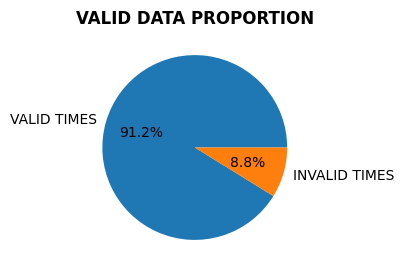

In [103]:
def good_format_time(time: datetime) -> int:
    """
    Check if the valid data respect 
    the format HOURS:MINUTES:SECONDS

    Args:
        Date: datetime
        Date to check its format

    Returns:
        int: Binary output
    """
    time = str(time)
    f_time = '00:00:00' 
    valid_len = len(f_time)
    
    # Get the index positions of colons in the string
    colon_idx = [idx for idx, ch in enumerate(f_time) if ch == ':']
    try:
        has_d2_dot = np.all([True for position in colon_idx if time[position] == ':'])
    except IndexError:
        has_d2_dot = False
    
    if len(time) == valid_len and has_d2_dot:
        return 1
    else:
        return 0


# If a trip has valid data for both columns: 'HORA LLEGADA CONDUCTOR' (1) & 'HORA DE INICIO DEL TRANSITO'(1)
df_waiting_hrs['VALID TIMES'] = df_waiting_hrs.pipe(
    lambda df: df['HORA LLEGADA CONDUCTOR'].apply(good_format_time) +
                df['HORA DE INICIO DEL TRANSITO'].apply(good_format_time)
)

# Check if both times are valid
valid_times = np.where(df_waiting_hrs['VALID TIMES'] == 2, 1, 0)
df_waiting_hrs['VALID TIMES'] = valid_times

# Check the proportion of valid times in valid data
df_vtimes_prop = df_waiting_hrs.iloc[:, -2:].sum()
df_vtimes_prop['INVALID TIMES'] = df_vtimes_prop["VALID DATA"] - df_vtimes_prop["VALID TIMES"]
# Graph
df_vtimes_prop[1:].plot(
    kind = 'pie',
    title = 'VALID DATA',
    autopct = '%.01f%%',
    figsize = (3, 3)
)
plt.title('VALID DATA PROPORTION', fontdict={'weight': 'bold'})
plt.show()

As you can see, we can have valid data over the columns **HORA LLEGADA CONDUCTOR** and **HORA DE INICIO DE TRANSITO**. However, it's not necessary consistent data that we can use to calculate the waiting hours. So we need to check what kind of values there are across the group of invalid times.

In [104]:
# Create a df that only contains the records who have invalid times
is_valid = df_waiting_hrs['VALID DATA'] == 1
inv_time = df_waiting_hrs['VALID TIMES'] == 0
df_inv_times = df_waiting_hrs.loc[is_valid & inv_time, df_waiting_hrs.columns[:-3]].copy()

# Let's check the 5 most common values and their frequencies in each variable.
dict_common_val = dict()

for col in df_inv_times.columns:
    df_common_val = pd.DataFrame( 
                    df_inv_times.loc[:, col].value_counts()[:5].reset_index() )
    df_common_val.columns = ['Value', 'Frequency']
    dict_common_val[col] = df_common_val
    
# Make a merge to find similar values between the variables
pd.merge(
    left = dict_common_val['HORA LLEGADA CONDUCTOR'],
    right = dict_common_val['HORA DE INICIO DEL TRANSITO'],
    on = 'Value',
    suffixes = ['_HLC', '_HIT'] #initials
)

,Value,Frequency_HLC,Frequency_HIT
0,-,106,136
1,FALSO FLETE,16,21
2,---,5,5
3,CANCELADO,5,5


Now, it's important to clarify the meaning of 2 words at this point:
* **FALSO FLETE (FAKE CALL):** It occurs when the customer cancels the service at the last minute. And the transport company has to charge an amount of money for the offense committed 
* **CANCELADO:** It happens when the customer cancels the service in time. So, any action will be taken about it.

It makes sense that I can't calculate anything with this kind of record, because the trip didn't happen. So, the plan is to exclude them and understand why there are values like '-' or '---'.  

In [105]:
# Find those trips that have '-' as a value
# dat: driver arrival time
dat = df_inv_times.iloc[:, 0].astype(str).str.contains('-')
# tst: transit start time 
tst = df_inv_times.iloc[:, 1].astype(str).str.contains('-')

# Get their indexes
idx_hyphen_val = df_inv_times[dat | tst].index

# Go to the original database
df_hyphen_val = df_TransportCompany.iloc[idx_hyphen_val, :].copy()

There are 3 columns can give me useful information about why there is this kind of values across these columns:
* **OBSERVACIONES (OBSERVATIONS):** This variable mentions about the irregularities with the assigned automobile in the trip.
* **COMENTARIOS (COMMENTARIES):** It gives the similar information than OBSERVACIONES column
* **STATUS:** It tells me if the trip was cancelled, finished or whatever. 

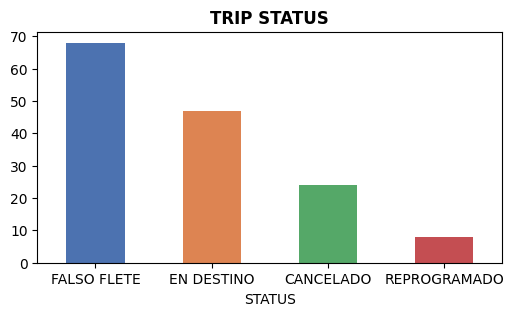

In [106]:
#Plot the Status values
my_pltt = sns.color_palette("deep")
(
    df_hyphen_val.
    loc[:, 'STATUS'].
    value_counts().
    plot(
        kind = 'bar',
        rot = 0,
        color = my_pltt,
        figsize = (6, 3)
    )
)
plt.title('TRIP STATUS', 
          fontdict = {'weight': 'bold',
                      'size': 'large'})
plt.show()

Well, it's very strange to see that there are trips that were made despite the fact that there was no valid time registered either in **HORA LLEGADA CONDUCTOR** and **HORA DE INICIO DE TRANSITO** or both. How can the transport company know if it has to charge the customer for hours of waiting without this information? This was a significant mistake by who did not do it.

On the other hand, we can see the other status are **FALSO FLETE (FAKE CALL)**, **CANCELADO (CANCELED)** and **REPROGRAMADO (REPROGRAMMED)**. And now it's more understandable why they decided to fill these camps with '-' values, because it means that in this group there are the trips that were not made. So, the plan is to change these values for one by default to make easier the task of filterting when we want to calculate the waiting hours, since as we could see there are some that are '-', '--' or '---'. Likewise, it's necessary to do the same with those ones that have values like **FALSO FLETE** or **CANCELADO**.

On the other hand, I still have null data across these columns, but I've decided to fill them with the same default value.

In [107]:
# Hyphen:
df_TransportCompany.loc[idx_hyphen_val, important_columns[:-1]] = 'Unregistered'

# Fake call or canceled:
fake_call_or_cancelled = df_TransportCompany.iloc[:, [23, 24]].isin(
    ['FALSO FLETE', 'CANCELADO']
).any(axis = 1)
df_TransportCompany.loc[fake_call_or_cancelled, important_columns[:-1]] = 'Unregistered'

# Null data: dat -> driver arrival time ; tst -> transit start time 
null_dat = df_TransportCompany.iloc[:, 23].isnull()
null_tst = df_TransportCompany.iloc[:, 24].isnull()
null_times = df_TransportCompany.loc[null_dat | null_tst, important_columns[:-1]].fillna(
    'Unregistered'
)
df_TransportCompany.loc[null_dat | null_tst, important_columns[:-1]] = null_times

# Invalid waiting hours
unregistered_cond = df_TransportCompany.iloc[:, [23, 24]].isin(
    ['Unregistered']
).any(axis = 1)
df_TransportCompany.loc[unregistered_cond, 'HORAS DE ESPERA'] = 'Invalid'

We should make sure that all the trips that have invalid times according to the df_waiting_hours have the value 'Invalid' in the **HORAS DE ESPERA** column. 

In [108]:
not_unregistered = [df_TransportCompany[col] != 'Unregistered' 
                   for col in important_columns[:-1]]
invalid_times = df_waiting_hrs['VALID TIMES'] == 0
(
    df_TransportCompany.loc[
    not_unregistered[0] & not_unregistered[1] & invalid_times,
    important_columns
    ]
)

,HORA LLEGADA CONDUCTOR,HORA DE INICIO DEL TRANSITO,HORAS DE ESPERA
1304,15:51:00,16:09:00.,NaN
2025,0.791667,0.820833,NaN


As you can see, we have two trips that don't respect what we mentioned before:
* In the column **HORA DE INICIO DEL TRANSITO** of row 1304, the times has a dot at the end. So, this is solved by removing it.
* In row 2025, there are two times expressed in float numbers. That doesn't make sense, that's why we're gonna replace them with 'Unregistered' value.

In [109]:
#Typo at the end
v_time = str(df_TransportCompany.loc[1304, important_columns[1]]).replace('.', '')
df_TransportCompany.loc[1304, important_columns[1]] = v_time
#Float values 
df_TransportCompany.loc[2025, important_columns[:-1]] = 'Unregistered'
df_TransportCompany.loc[2025, important_columns[-1]] = 'Invalid'

In [110]:
def are_valid_whours(waiting_hrs: pd.Series) -> pd.Series:
    """
    Check if the driver had to wait 
    2 hours or more to start with the trip.

    Args: 
        Waiting_hrs: pd.Series
            Waiting hours of a trip
    Returns:
        pd.Series
            Assign Not WH for those trips that 
            does not satisfy the condition
    """
    waiting_hrs[waiting_hrs < 2] = 0
    return waiting_hrs

def convert_time_to_float(times: pd.Series) -> pd.Series:
    """
    It converts the time in float where 
    the decimal part is the hours and the 
    fractional part is the minutes

    Args:
        times: pd.Series
            Times registered
    Returns:
        pd.Series
            Array of times cast to float numbers
    """
    float_times = times.astype(str).apply(
        lambda time: time[:2] + '.' + time[3:5] #HH:MM:SS
        ).astype(float)
    return float_times


# Valid data to get the waiting hours:
valid_dat = df_TransportCompany['HORA LLEGADA CONDUCTOR'] != 'Unregistered'
valid_tst = df_TransportCompany['HORA DE INICIO DEL TRANSITO'] != 'Unregistered'

# Convert the times into float numbers to do the substraction operation
df_float_times = df_TransportCompany.loc[valid_dat & valid_tst, important_columns[:-1]].apply(
    convert_time_to_float
)
df_TransportCompany.loc[valid_dat & valid_tst, 'HORAS DE ESPERA'] = are_valid_whours(
        (df_float_times.iloc[:, 1] - df_float_times.iloc[:, 0]).round(2)
        )

#Check that there is no null data
(df_TransportCompany[important_columns].isnull() * 1).sum()

HORA LLEGADA CONDUCTOR         0
HORA DE INICIO DEL TRANSITO    0
HORAS DE ESPERA                0
dtype: int64

---

<h4 style = 'font-family: Verdana; text-align: center'><strong>NULL-DATA IN TRANSFER DATE</strong></h4>

Another column that we have a significant amount of null data is **FECHA TRANSFERENCIA (Transfer Date)**. And as it was mentioned at the beginning of this noteebook, it consists of the date that the driver gets the necessary money for his expenses during the trip.

The plan is to use the same date as the **FECHA INICIO (Start Date)** column, because the driver always receive his transfer on the same day that he starts the trip. But first, we have to check if these dates are less or equal than those in **FECHA DE LLEGADA (Arrival date)** column, otherwise that wouldn't be consistent. 

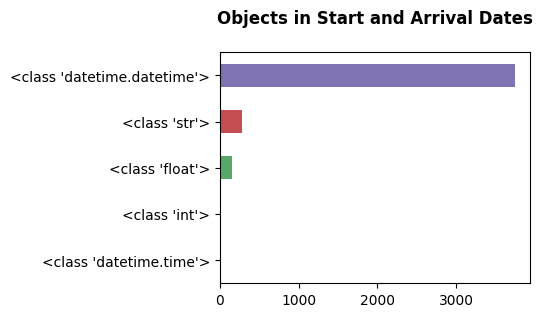

In [111]:
(
    df_TransportCompany.
    melt(
        value_vars = ['FECHA DE INICIO',
                      'FECHA DE LLEGADA'],
        value_name = 'DATES'
        ).
    apply(
        lambda x: type(x['DATES']),
        axis = 1
        ).
    value_counts().
    sort_values(
        ascending = True
        ).
    plot(
        kind ='barh',
        color = my_pltt,
        figsize = (4, 3)
    )
)
plt.title('Objects in Start and Arrival Dates\n', 
          fontdict = {'weight': 'bold',
                      'size': 'large'})
plt.show()

There are different objects surrounding these two columns and this will be a problem when we want to perform operations with them. So it's important to cast them to datetime.datetime object. But meanwhile, we can see if those that have the correct type accomplish the previous condition (ARRIVAL TIME >  START TIME).

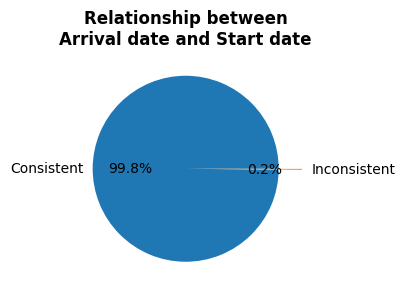

In [112]:
trip_dates = DatetimesObj(df_tc=df_TransportCompany)
(
    pd.Series({
        'Consistent': trip_dates.filter_by_relationship().shape[0],
        'Inconsistent': trip_dates.filter_by_relationship(consistent=False).shape[0]
        }).
    plot(
        kind = 'pie',
        explode = [0, 0.25],
        autopct = '%.01f%%',
        figsize=(3, 4)
    )
)
plt.title('Relationship between\nArrival date and Start date', 
          fontdict = {'weight': 'bold',
                      'size': 'large'})
plt.show()

We'll need to check other variables to confirm if either the start date or the arrival date is incorrect to replace it. And the following columns can give us relevant information about it:
* **FECHA**: When the trip was recorded in the dataset.
* **ORIGEN** and **DESTINO**: These columns make up the route. And if we see others with the same data, we can estimate the journey time.
* **FECHA DE TRANSFERENCIA**: If there's not a null value, then it can help us to confirm that the start date is correct.

In [113]:
(
    trip_dates.
    filter_by_relationship(consistent=False).
    loc[:, ['FECHA', 'FECHA DE INICIO', 'FECHA DE LLEGADA', 
         'ORIGEN', 'DESTINO', 'FECHA TRANSFERENCIA']]
)

,FECHA,FECHA DE INICIO,FECHA DE LLEGADA,ORIGEN,DESTINO,FECHA TRANSFERENCIA
403,2023-08-07,2023-08-07 00:00:00,2023-07-08 00:00:00,SUC. TRUJILLO,SUC. HUARAZ,NaN
476,2023-08-09,2023-08-09 00:00:00,2023-08-08 00:00:00,MACROPOLIS,RMB VES,2023-08-09 00:00:00
1631,2023-09-18,2023-09-18 00:00:00,2023-08-19 00:00:00,CD LURIN,SUC. AREQUIPA,18/09 Y 20/09


All the start dates are correct by checking in **FECHA** and **FECHA TRANSFERENCIA** column, even though there's a NaN value in record 403, but we'll asume that the start date is correct anyway. On the other hand, we'll have to look at other trips with a similar route to estimate the journey time and thus calculate the values in **FECHA DE LLEGADA** column.

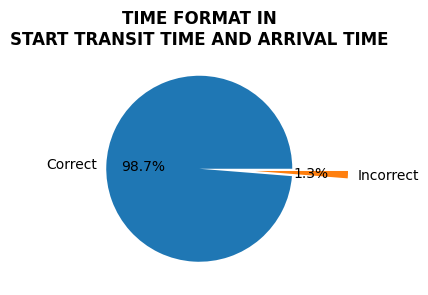

Correct      1790
Incorrect      23
dtype: int64

In [114]:
# Use the columns Transit Start Time and Arrival Time to check the format time
start_arr_times = trip_dates.filter_by_relationship().loc[:, 
                                                   ['HORA DE INICIO DEL TRANSITO', 
                                                    'HORA DE LLEGADA DESTINO']
                                                   ].copy()
start_arr_times['Correct_Format'] = start_arr_times.loc[:, 
                                                        ['HORA DE INICIO DEL TRANSITO',
                                                         'HORA DE LLEGADA DESTINO']].map(
                                                             good_format_time
                                                             ).sum(axis = 1)

# Visualize the proportion of correct times in both columns
time_format = start_arr_times['Correct_Format'].value_counts()
time_format[1] = time_format[[1, 0]].sum(); time_format = time_format[[2, 1]]
time_format.index = ['Correct', 'Incorrect']
time_format.name = None

#Graph
time_format.plot(
    kind = 'pie',
    autopct = '%.01f%%',
    figsize = (3, 4),
    explode = (0, 0.6)
)
plt.title('TIME FORMAT IN\nSTART TRANSIT TIME AND ARRIVAL TIME', 
          fontdict = {'weight': 'bold',
                      'size': 'large'})
plt.show()
time_format

In [115]:
start_arr_times['Correct_Format'] = start_arr_times.apply(
    lambda x:
        good_format_time(x['HORA DE INICIO DEL TRANSITO']) + 
        good_format_time(x['HORA DE LLEGADA DESTINO']), axis = 1
    )
start_arr_times.Correct_Format.value_counts()

Correct_Format
2    1790
1      14
0       9
Name: count, dtype: int64

We've removed all the null data over the **HORA DE INICIO DEL TRANSITO** column in the above section (NULL DATA IN WAITING HOURS), so the most likelihood is that there are Unregistered values in this column and for this reason we get times with a incorrect format.

In [116]:
(
    start_arr_times.loc[
        start_arr_times['Correct_Format'] != 2,
        'HORA DE INICIO DEL TRANSITO'
        ].
    value_counts()[:5]
)

HORA DE INICIO DEL TRANSITO
Unregistered    12
13:15:00         1
13:51:00         1
17:01:00         1
09:50:00         1
Name: count, dtype: int64

In [117]:
(
    start_arr_times.loc[
        start_arr_times['HORA DE INICIO DEL TRANSITO'] == 'Unregistered',
        'HORA DE LLEGADA DESTINO'
        ].
    value_counts(
        dropna = False
    )
)

HORA DE LLEGADA DESTINO
NaN         8
-           1
17:58:00    1
09:49:00    1
20:24:00    1
Name: count, dtype: int64

It makes sense there are null data in the arrival time column, since these trips weren't made. So we can fill them with Unregistered too. And the one that has '-' as its value should have to change for the same.

In [118]:
start_arr_times['HORA DE LLEGADA DESTINO'] = start_arr_times['HORA DE LLEGADA DESTINO'].fillna('-')

null_arr_time = start_arr_times[
    start_arr_times['HORA DE LLEGADA DESTINO'] == '-'
    ].index
df_TransportCompany.loc[null_arr_time, 'HORA DE LLEGADA DESTINO'] = 'Unregistered'

On the other hand, we have a inconsistent problem here. Since if it supposed that there wasn't a start transit time, how is it possible that there are times registered in arrival times?

In [119]:
unrgt_times = start_arr_times[
        (start_arr_times['HORA DE INICIO DEL TRANSITO'] == 'Unregistered')
        & (start_arr_times['HORA DE LLEGADA DESTINO'] != '-')
].index

(
    df_TransportCompany.
    loc[ 
    unrgt_times,
    'STATUS'
    ].
    value_counts()
) 

STATUS
EN DESTINO    3
Name: count, dtype: int64

The status of the trips that have a consistent time in **ARRIVAL TIME** column, but an Unregistered value in the **START TRANSIT TIME**, is **EN DESTINO (AT DESTINATION)**. This means that they were made. But, it's pointless. So this data won't be useful for estimating the journey time, so we'll fill these values with Unregistered. 

In [120]:
df_TransportCompany.loc[unrgt_times, 'HORA DE LLEGADA DESTINO'] = 'Unregistered'

In [121]:
(
    start_arr_times[
    (start_arr_times['Correct_Format'] != 2)
    & (start_arr_times['HORA DE INICIO DEL TRANSITO'] != 'Unregistered')
    & (start_arr_times['HORA DE LLEGADA DESTINO'] != '-')
    ]
)

,HORA DE INICIO DEL TRANSITO,HORA DE LLEGADA DESTINO,Correct_Format
1332,07:45:00,16:23:00.,1
1734,12:34:00,6.51.00,1
1963,16:01:00,18:38:00 a. m.,1


In [122]:
# Fix the last trips with an inconsistent time in ARRIVAL TIME column
df_TransportCompany.loc[1332, 'HORA DE LLEGADA DESTINO'] = '16:23:00'
df_TransportCompany.loc[1734, 'HORA DE LLEGADA DESTINO'] = '06:51:00'
df_TransportCompany.loc[1963, 'HORA DE LLEGADA DESTINO'] = '18:38:00'

# Update the content
trip_dates.dt_table = df_TransportCompany 

Once we've fixed all the start transit times and arrival times of those trips that have datetime objects over these columns and respect the condition: **Start Date < Arrival Date**. We'll be able to calculate the arrival date in those trips that don't fulfill the condition and estimate the arrival times where there are 'Unregistered' values, despite the fact that they have a start transit time.    

In [124]:
trip_duration = TripDuration(df_tc=df_TransportCompany)

# Inconsistent arrival times
incon_arr_times = trip_duration.get_correct_arr_date(
    trip_dates.filter_by_relationship(consistent=False)
    )

# Unregistered arrival times
unrg_arr_times = trip_dates.filter_by_relationship()
unrg_arr_times = unrg_arr_times[unrg_arr_times.apply(
    lambda x: x['HORA DE LLEGADA DESTINO'] == 'Unregistered' and
        x['HORA DE INICIO DEL TRANSITO'] != 'Unregistered',
        axis = 1
)]
unrgt_arr_times = trip_duration.get_correct_arr_date(unrg_arr_times)

# Combine them 
correct_arr_dates = pd.concat([incon_arr_times, unrgt_arr_times])

# Reeplace them in the original db
df_TransportCompany.loc[correct_arr_dates.index, 'FECHA DE LLEGADA'] = correct_arr_dates.apply(
    lambda x: x.date()
)
df_TransportCompany.loc[correct_arr_dates.index, 'HORA DE LLEGADA DESTINO'] = correct_arr_dates.apply(
    lambda x: x.time()
)
# Autofill the transfer date column with the start dates
df_TransportCompany.loc[
    trip_dates.dt_table.index,'FECHA TRANSFERENCIA'
    ] = df_TransportCompany.loc[
        trip_dates.dt_table.index, 'FECHA DE INICIO'
        ]
# Update the content and check that everything is okay
trip_dates.dt_table = df_TransportCompany
if trip_dates.filter_by_relationship(consistent=False).shape[0] == 0:
    print('All the trips respect the condition: Star date < Arrival date')

All the trips respect the condition: Star date < Arrival date


Now, we have to deal with those trips that have another kind of dtype in these columns. Let's start with those that are str objects and try to cast them to datetime objects.

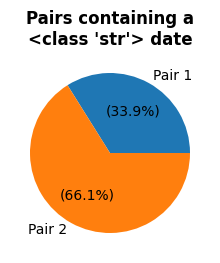

In [125]:
strtimes = StrTimes(df_tc=df_TransportCompany)
strtimes.presence_in_db()

In [131]:
strtimes.table_pairs

freq
Pair Date             Dtype                            
1    FECHA DE INICIO  <class 'datetime.datetime'>    59
     FECHA DE LLEGADA <class 'str'>                  59
2    FECHA DE INICIO  <class 'str'>                 115
     FECHA DE LLEGADA <class 'str'>                 115

As you can see, we have two groups with str values. One where both dates are strings and the other where the arrival date is the only one. So, let's find out the reason for this. 

In [132]:
# Get the groups
groups = DateTypes(df_tc=df_TransportCompany)
pair_1 = groups.customized_dtypes(dtype_dd=datetime, dtype_ad=str)
pair_2 = groups.customized_dtypes(dtype_ad=str, dtype_dd=str)
(
    pair_1['FECHA DE LLEGADA']
    .value_counts()
)

FECHA DE LLEGADA
-              50
FALSO FLETE     9
Name: count, dtype: int64

In the first group, there are trips that weren't made and others where the arrival date was filled with a '-'.

Recall: **FALSO FLETE (Fake call)** means when the customer cancels the service at the last moment. 

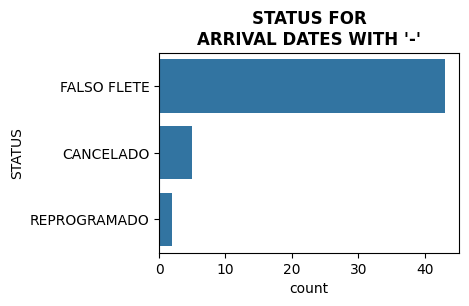

In [119]:
fig  = plt.figure(figsize=(3, 2))

ax = fig.add_axes([0, 0, 1, 1])
(
    pd.merge(
        left = pair_1[pair_1['FECHA DE LLEGADA'] == '-'], 
        right = df_TransportCompany[['STATUS']],
        left_index=True, right_index=True
    ).
    pipe(
        lambda df: 
            sns.countplot(
                data=df, y = 'STATUS',
                )
    )
)
ax.set_title("STATUS FOR\nARRIVAL DATES WITH '-'", fontdict={'weight': 'bold'})

plt.show()

It turns out that they are also trips that weren't made: **FALSO FLETE (FAKE CALL)**, **CANCELADO (CANCELLED)** and **REPROGRAMADO (REPROGRAMMED)**. And if the data is consistency, then we will be in the same situation with the **ARRIVAL TIME** column:

In [133]:
(
    pd.merge(
        left = pair_1,
        right = df_TransportCompany.loc[:, ['HORA DE LLEGADA DESTINO']],
        left_index=True, right_index=True
    ).
    value_counts('HORA DE LLEGADA DESTINO')
)

HORA DE LLEGADA DESTINO
-              50
FALSO FLETE     9
Name: count, dtype: int64

Ta-da! So, we need to fill the columns related with the dates of these trips with Unregistered values.

In [134]:
dates_columns = ['FECHA DE INICIO', 'FECHA DE LLEGADA', 'FECHA TRANSFERENCIA',
                 'HORA DE INICIO DEL TRANSITO', 'HORA DE LLEGADA DESTINO']

df_TransportCompany.loc[pair_1.index, dates_columns] = 'Unregistered'

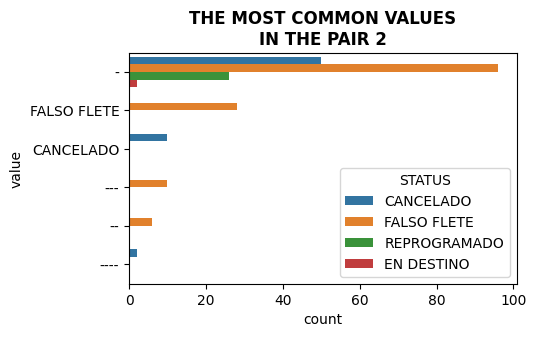

In [135]:
# Let's see what happened in the pair 2
plt.figure(figsize=(5, 3))
(
    pd.merge(
        left = pair_2, 
        right = df_TransportCompany['STATUS'],
        left_index=True, 
        right_index=True
        ).
    melt(id_vars=['STATUS']).
    pipe(
        lambda df:
            sns.countplot(
                data = df, 
                y = 'value',
                hue = 'STATUS',
                order = df.value.value_counts().index
            )
    )
 )
plt.title('THE MOST COMMON VALUES\nIN THE PAIR 2', 
          fontdict = {'weight': 'bold'})
plt.show()

You might think that we're in the same situation with the pair 1, but that's not entirely true. Because there are trips whose status is **EN DESTINO (At Destination)** and have a '-' either as a start or arrival date. So, we need to find out if it's possible to get these dates through the trip duration table that we've built.

Recall: **At Destination** status means when the trip was made.

In [136]:
(
    pd.merge(
        left=pair_2,
        right= df_TransportCompany[df_TransportCompany['STATUS'] == 'EN DESTINO'],
        left_index=True,
        right_index=True,
        suffixes = ['_x', '']
    ).
    loc[
        :, ['FECHA', 'HORA'] + dates_columns + ['STATUS']
        ].T
)

,1224
FECHA,2023-09-02 00:00:00
HORA,13:00:00
FECHA DE INICIO,-
FECHA DE LLEGADA,-
FECHA TRANSFERENCIA,NaN
HORA DE INICIO DEL TRANSITO,Unregistered
HORA DE LLEGADA DESTINO,-
STATUS,EN DESTINO


We have an observation with this particular behavior, but it's going to be impossible to fix it. Because we only have the date when the trip was registered in the database, but that's not useful for our purposes. So we have to take the same actions as for the pair 1.

In [137]:
df_TransportCompany.loc[pair_2.index, dates_columns] = 'Unregistered' 

# Check that there are no more str values
not_str = ~(df_TransportCompany.loc[:, 
                                    ['FECHA DE INICIO', 'FECHA DE LLEGADA']].isin(
                                    ['Unregistered']).any(axis = 1))
strtimes.str_table = df_TransportCompany[not_str]

if strtimes.str_table.shape[0] == 0:
    print('There are no more str values')

# Remove the record 1224 for being inconsistency
df_TransportCompany.drop(1224, axis = 0, inplace = True)

There are no more str values


Now, it's time to deal with the dates that are float values and try to understand why they are there and if it's possible to replace them with the trip duration table.

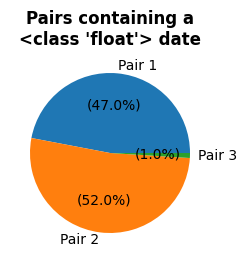

In [138]:
floattimes = FloatTimes(df_tc=df_TransportCompany)
floattimes.presence_in_db()

In [140]:
floattimes.table_pairs

freq
Pair Date             Dtype                            
1    FECHA DE INICIO  <class 'datetime.datetime'>    47
     FECHA DE LLEGADA <class 'float'>                47
2    FECHA DE INICIO  <class 'float'>                52
     FECHA DE LLEGADA <class 'float'>                52
3    FECHA DE INICIO  <class 'float'>                 1
     FECHA DE LLEGADA <class 'datetime.datetime'>     1

In this case, we have 3 pairs where at least one of the dates is a float object. And if there are not null values in the start transit time column for pair 1, then we can get the arrival dates from the trip duration table. 

In [142]:
df_pair_1 = groups.customized_dtypes(dtype_dd=datetime, dtype_ad=float)
df_pair_1['FECHA DE LLEGADA'].fillna('Missing').value_counts()

FECHA DE LLEGADA
Missing    47
Name: count, dtype: int64

The NaN are floating-point values for NumPy. The data in this column won't be useful anyway, so it's not a problem

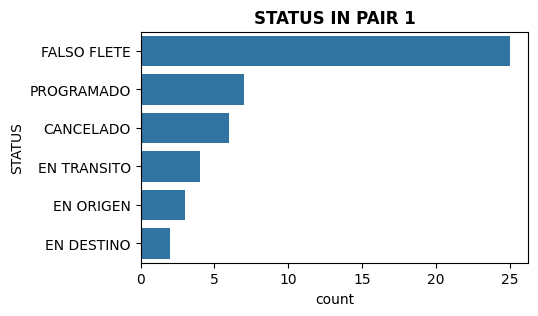

In [143]:
df_pair_1 =pd.merge(
        left = df_pair_1,
        right = df_TransportCompany[['STATUS']],
        left_index = True, 
        right_index = True
        )

# Which status do we have? 
plt.figure(figsize=(5, 3))
(
    df_pair_1.
    pipe(
        lambda df:
        sns.countplot(
            data = df,
            y = 'STATUS',
            order = df_pair_1['STATUS'].value_counts().index
        )
    )
)
plt.title('STATUS IN PAIR 1', fontdict={'weight': 'bold'})
plt.show()

* In the pair 1, we have found 3 new statuses that we didn't see before:
    * PROGRAMADO (Scheduled): A trip that is scheduled for a future date.   
    * EN TRANSITO (On the move): When the driver is on the way of the destination.
    * EN ORIGEN (At origin): If the driver is at the starting point, but there are not instruction to start with the trip.
* For those trips whose status is either **FALSO FLETE (Fake Call)** or **CANCELADO (Cancelled)**, we'll need to fill their arrival data with the 'Unregistered' value.
* For the trips with the following statutes: **EN ORIGEN (At origin)**, **EN TRANSITO (On the move)** and **EN DESTINO (At destination)**. We'll use the trip duration table to get their arrival dates, assuming there was no problem with the trips that were at the starting point.
* There will be a inconsistency problem if the start transit time has been recorded in those trips whose status is **PROGRAMADO (Scheduled)**, because it assumes that these trips are scheduled for a future date. So we need to check them before taking any action. 

In [144]:
# 1) Fill with Unregistered values the missing ones.
not_done = df_pair_1[df_pair_1['STATUS'].isin(['FALSO FLETE', 'CANCELADO'])]
df_TransportCompany.loc[not_done.index, 'FECHA DE LLEGADA'] = 'Unregistered'

# 2) Use the trip duration table to get the arrival dates
done_trips = pd.merge(
    left = df_pair_1[df_pair_1['STATUS'].isin(['EN ORIGEN', 'EN TRANSITO','EN DESTINO'])],
    right = df_TransportCompany[['HORA DE INICIO DEL TRANSITO', 'ORIGEN', 'DESTINO']],
    left_index = True,
    right_index = True
)
# Assign a default start transit time to those that have Unregistered values
np.random.seed(42)
done_trips.loc[
    done_trips['HORA DE INICIO DEL TRANSITO'] == 'Unregistered', 
    'HORA DE INICIO DEL TRANSITO'
    ] = time(np.random.randint(13, 19), 0, 0)
correct_ad = trip_duration.get_correct_arr_date(done_trips)
# Check if there are null dates
correct_ad.isnull().sum()

np.int64(3)

It returned 3 arrival dates as a null date, because there are routes that weren't in the trip duration table. So we'll have to fill them with the Unregistered value.  

In [145]:
# Fill the arrival date and time columns with Unregistered values
for col in ['FECHA DE LLEGADA', 'HORA DE LLEGADA DESTINO']:
    df_TransportCompany.loc[
    correct_arr_dates[correct_arr_dates.isnull()].index,
    col] = 'Unregistered'
    
# Record the arrival date and time for others.
valid_ad = correct_ad.dropna()
df_TransportCompany.loc[valid_ad.index, 'FECHA DE LLEGADA'] = valid_ad.apply(lambda x: x.date())
df_TransportCompany.loc[valid_ad.index, 'HORA DE LLEGADA DESTINO'] = valid_ad.apply(lambda x: x.time())
# Change their status to 'EN DESTINO'
df_TransportCompany.loc[valid_ad.index, 'STATUS'] = 'EN DESTINO'

In [148]:
scheduled_trips = pd.merge(
        left = df_pair_1[df_pair_1['STATUS'] == 'PROGRAMADO'],
        right = df_TransportCompany[['HORA DE INICIO DEL TRANSITO', 'ORIGEN', 'DESTINO']],
        left_index = True, right_index = True
        )

scheduled_trips.loc[:, 'HORA DE INICIO DEL TRANSITO'].value_counts()

HORA DE INICIO DEL TRANSITO
Unregistered    7
Name: count, dtype: int64

It makes sense that there are only Unregistered values in the start transit time for the scheduled trips.

Now, we can get the transfer date of the trips whose status is either **EN DESTINO (At destination)**, **EN TRANSITO (On the move)** or **EN ORIGEN (At origin)** with their respective start date. 

In [150]:
valid_status = df_TransportCompany['STATUS'].isin(['EN DESTINO', 'EN TRANSITO', 'EN ORIGEN'])

df_TransportCompany.loc[
    valid_status, 'FECHA TRANSFERENCIA'
    ] = df_TransportCompany.loc[
        valid_status, 'FECHA DE INICIO'
        ]

# For the rest, we will fill the transfer date with Unregistered values.
df_TransportCompany["FECHA TRANSFERENCIA"] = df_TransportCompany['FECHA TRANSFERENCIA'].fillna('Unregistered')

At this point, we know that the trips with unregistered values in either the departure or arrival date are those that were not taken. So, it's important to make sure that the columns related to the time are filled with Unregistered values.

In [151]:
df_TransportCompany.loc[
        (df_TransportCompany['FECHA DE LLEGADA'] == 'Unregistered')
        | (df_TransportCompany['FECHA DE INICIO'] == 'Unregistered'), 
        ['FECHA DE LLEGADA', 'FECHA DE INICIO', 'HORA DE LLEGADA DESTINO',
         'HORA DE INICIO DEL TRANSITO']
    ] = 'Unregistered'

We will do the same with those trips that have null values in any of these columns and whose status is not at destination, on the move or at origin.

In [152]:
df_TransportCompany.loc[
    (df_TransportCompany['FECHA DE INICIO'].isnull()| 
     df_TransportCompany['FECHA DE LLEGADA'].isnull() ) & 
    ~( df_TransportCompany['STATUS'].isin(['EN DESTINO', 'EN TRANSITO', 'EN ORIGEN']) ),
['FECHA DE LLEGADA', 'FECHA DE INICIO', 
 'HORA DE LLEGADA DESTINO', 'HORA DE INICIO DEL TRANSITO']
] = 'Unregistered' 

In [153]:
(
df_TransportCompany.loc[
    df_TransportCompany['FECHA DE INICIO'].isnull() | df_TransportCompany['FECHA DE LLEGADA'].isnull(),
 ['FECHA DE INICIO', 'FECHA DE LLEGADA', 'HORA DE INICIO DEL TRANSITO', 
  'HORA DE LLEGADA DESTINO', 'STATUS']
]
)

,FECHA DE INICIO,FECHA DE LLEGADA,HORA DE INICIO DEL TRANSITO,HORA DE LLEGADA DESTINO,STATUS
1647,NaN,NaN,Unregistered,NaN,EN DESTINO
2026,NaN,NaN,Unregistered,NaN,EN TRANSITO
2050,2023-09-30 00:00:00,NaN,Unregistered,NaN,EN TRANSITO
2062,2023-10-01 00:00:00,NaN,16:36:00,NaN,EN TRANSITO
2076,2023-10-02 00:00:00,NaN,Unregistered,NaN,EN ORIGEN


They are the only trips that have null values in either the start or arrival date, but their status tells us that they were not cancelled. Below are the actions that we'll take:
* It will be impossible to do anything for the trips 1647 and 2026. So we'll have to delete them from the dataset.
* Since we have the start transit time and start date for the trip 2062, we can find its arrival date.
* We only have the start date for the trips 2050 and 2076, but we can assign them a random start transit time to get their arrival dates.

We hope that the routes of the trips in the second and third point are in the trip duration table to avoid inconveniences.

In [154]:
# Delete trips
df_TransportCompany.drop([1647, 2026], axis = 0, inplace = True)

# Assign a random start transit time
r_stt = time(np.random.randint(13, 17), 0, 0)
df_TransportCompany.loc[[2050, 2076], 'HORA DE INICIO DEL TRANSITO'] = r_stt

# Find their arrival dates
(
    trip_duration.
    get_correct_arr_date(
        df_TransportCompany.loc[[2050, 2062, 2076], :]).
    value_counts(dropna = False)
)


NaT    3
Name: count, dtype: int64

Unfortunately, their routes are not in the trip duration table. But since their status is no **En destino (At destination)**, it will be OK to fill the arrival date and time with Unregistered values. 

In [155]:
df_TransportCompany.loc[[2050, 2062, 2076], 
                        ['HORA DE LLEGADA DESTINO', 
                         'FECHA DE LLEGADA']] = 'Unregistered'
df_TransportCompany[
    ['FECHA DE INICIO', 'FECHA DE LLEGADA',
     'HORA DE INICIO DEL TRANSITO', 'HORA DE LLEGADA DESTINO',]
    ].isnull().sum()     

FECHA DE INICIO                0
FECHA DE LLEGADA               0
HORA DE INICIO DEL TRANSITO    0
HORA DE LLEGADA DESTINO        0
dtype: int64

<hr>
<h4 style = "text-align: center"><strong>NULL-DATA IN BUDGET COLUMN</strong></h4>
<p>
This is directly related to the Transfer Date column, so if we encounter an 'Unregistered' value in any trip, we need to do the same for this field. Otherwise, we'll have to get this information from the data provided by the trips with the same route. But it will be checked if the variables FAMILIA and NUEVO / SEMI NUEVO affect the value of the budget. </p> 


In [138]:
unrg_dateTransf = Budget(df_tc=df_TransportCompany) 
unrg_dateTransf.dtypes()

POR RENDIR S/
<class 'float'>    111
<class 'int'>       91
<class 'str'>       49
Name: count, dtype: int64

It's strange to see int values in this column despite the fact the transfer date was not recorded. But there may be an explanation. Maybe the trip was canceled, but the payment of the budget to the driver was advanced. Anyway, this information is useful for us, because we can know how much money the driver receives for a particular route.

In [139]:
# Dealing with null values
null_budget = unrg_dateTransf.budget_table[unrg_dateTransf.budget_table['POR RENDIR S/'].isnull()]
df_TransportCompany.loc[
        null_budget.index,
        'POR RENDIR S/' 
        ] = 'Unregistered'
# Meeting the str values
unrg_dateTransf.dtypes(str) 

POR RENDIR S/
-              23
---            16
FALSO FLETE     4
--              3
-------         2
CANCELADO       1
Name: count, dtype: int64

In [140]:
str_budgets = unrg_dateTransf.budget_table.loc[
        unrg_dateTransf.budget_table['POR RENDIR S/'].astype(str).str.contains('-|FA|CA')
        ]
# Check the status
str_budgets['STATUS'].value_counts()


STATUS
CANCELADO       24
FALSO FLETE     18
REPROGRAMADO     7
Name: count, dtype: int64

These trips were not made, so we need to do the same with as null values:

In [141]:
df_TransportCompany.loc[
    str_budgets.index, 'POR RENDIR S/'
] = 'Unregistered'

Make sure there are only two dtypes in the budget column: str and int. And the string budgets must be Unregisterd values.

In [142]:
# Update content after manipulating the data in Budget column.
unrg_dateTransf.table_tc = df_TransportCompany
unrg_dateTransf.dtypes()

POR RENDIR S/
<class 'str'>    160
<class 'int'>     91
Name: count, dtype: int64

Now, it's time to see what happens with the trips that have a valid transfer date. We'll have to build a table that contains the budget by the route, automobile type and whether it's new or used in order to fill in null or invalid data in the Budget column.  

In [143]:
valid_transf_date = Budget(df_tc = df_TransportCompany, transf_date = True)
budget_table_vtd = valid_transf_date.budget_table #vtd = valid transfer date
valid_transf_date.dtypes()

POR RENDIR S/
<class 'int'>      1367
<class 'float'>     385
<class 'str'>        86
Name: count, dtype: int64

In [144]:
(
    budget_table_vtd['POR RENDIR S/'].
    isnull().
    sum()
)

384

The budget is a discrete variable, so it cannot be possible to have float values. But, this is due to the presence of null data in this column. As we can see almost the 100% of float values are nulls (384/385). We will have to fill them with the budget table that we are going to build with the consist data.  

In [145]:
valid_transf_date.dtypes(str)

POR RENDIR S/
-              75
---             6
-------         3
----            1
ESCOLTA 500     1
Name: count, dtype: int64

This is a similar situation to those trips that don't have registered transfer date. Let's check if they were made or not: 

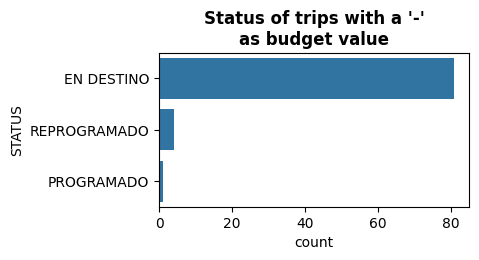

In [146]:
# Visualize the different status present:
plt.figure(figsize = (4, 2))
(
valid_transf_date.
budget_table.loc[
        valid_transf_date.
        budget_table['POR RENDIR S/'].astype(str).str.contains('-|E')
].
pipe(
    lambda df:
        sns.countplot(
            data = df,
            y = 'STATUS',
        )
)
)
plt.title("Status of trips with a '-'\nas budget value",
          fontdict = {'weight': 'bold'})
plt.show()

<p>Most of the trips that have a registered transfer date and '-' value as a budget have been made (EN DESTINO). So, when we build the budget table, we will be able to get the correct amounts. On the other hand, there are also reprogrammed (REPROGRAMADO) and programmed (PROGRAMADO) trips, so we need to fill this field with <i>"Unregistered".</i></p>

In [147]:
cond_status = budget_table_vtd['STATUS'].isin(['REPROGRAMADO', 'PROGRAMADO'])
cond_hyphen = budget_table_vtd['POR RENDIR S/'].astype(str).str.contains('-')
# Replace the budget field for these trips 
df_TransportCompany.loc[
    budget_table_vtd.loc[cond_status & cond_hyphen].index,
    ['FECHA TRANSFERENCIA', 'POR RENDIR S/', 'STATUS']
]

,FECHA TRANSFERENCIA,POR RENDIR S/,STATUS
1463,-,-,REPROGRAMADO
1566,-------,-------,REPROGRAMADO
1576,-------,-------,REPROGRAMADO
1584,-------,-------,REPROGRAMADO
1842,2023-09-23 00:00:00,-,PROGRAMADO


<p>It's curious to see these kind of values in the transfer date despite the fact we have set to only get the trips with a valid value for this field. We will have to <i>"kill two birds with one stone"</i>.</p>

In [148]:
df_TransportCompany.loc[
    budget_table_vtd.loc[cond_status & cond_hyphen].index,
    ['FECHA TRANSFERENCIA', 'POR RENDIR S/']
] = 'Unregistered'

<h5 style = "color: brown"><u>Let's start with building the budget table ⛏️💵</u></h5>

<p style = "font-family: Verdana">
Let's look how the  Budget behaves according to the variables `FAMILIA` and `NUEVO / SEMINUEVO` to determine if they are related.
</p>

In [149]:
first_cond = ~(df_TransportCompany['STATUS'].isin(
    ['FALSO FLETE, CANCELADO, PROGRAMADO, REPROGRAMADO']
    ))
second_cond = df_TransportCompany['POR RENDIR S/'].apply(lambda budget: type(budget) == int )
cols = ['ORIGEN', 'DESTINO', 'POR RENDIR S/', 'FAMILIA', 'NUEVO / SEMINUEVO', 'LOCAL / REGIONAL']
# Get the table
budget_table = df_TransportCompany.loc[first_cond & second_cond, cols].copy()
budget_table['ROUTE'] = df_TransportCompany.apply(
                            lambda trip: trip['ORIGEN'] + ' - ' + trip['DESTINO'], axis = 1
                                                )

Certain problems:
<ul>
    <li>
    There are two values that are the same in the group of families, only that one is in CAPITAL letters: `Automóviles` and `AUTOMÓVILES`
    </li>
</ul>

In [150]:
budget_table['FAMILIA'].unique().tolist()

['CAMIONES', 'BUSES', 'VANS', 'Automóviles', 'AUTOMÓVILES']

<ul>
<li>
    Something similar happens with the other variable where we have the condition `SEMINUEVO` and `SEMINUEVA`
</li>
</ul>

In [151]:
budget_table['NUEVO / SEMINUEVO'].unique().tolist()

['NUEVO', 'SEMINUEVO', nan, 'SEMINUEVA']

Next task: As we can see, there are trips that have a null data for this field. But if we identify the route and the budget received, we could know the condition of these cars.    

In [152]:
# Let's replace them
budget_table.loc[budget_table['FAMILIA'] == 'Automóviles', 'FAMILIA'] = 'AUTOMÓVILES'
budget_table.loc[budget_table['NUEVO / SEMINUEVO'] == 'SEMINUEVA', 'NUEVO / SEMINUEVO'] = 'SEMINUEVO'

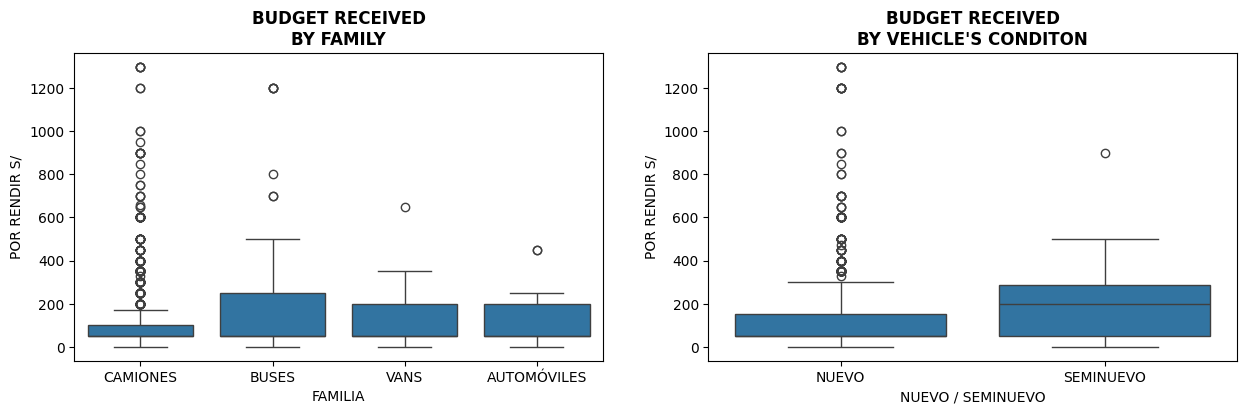

In [153]:
# Plot how the distribution of the budget behave by the variables family and condition
fig = plt.figure(figsize = (15, 4))
#Family
ax1 = fig.add_subplot(121)
sns.boxplot(data = budget_table, x='FAMILIA', y='POR RENDIR S/')
ax1.set_title('BUDGET RECEIVED\nBY FAMILY', fontdict = {'weight': 'bold'})
# Condition
ax2 = fig.add_subplot(122)
sns.boxplot(data = budget_table, x='NUEVO / SEMINUEVO', y= 'POR RENDIR S/')
ax2.set_title("BUDGET RECEIVED\nBY VEHICLE'S CONDITON", fontdict = {'weight': 'bold'})
plt.show()

In [154]:
families = budget_table['FAMILIA'].unique()
stats_families = []
for fam in families:
    budget = budget_table.loc[budget_table['FAMILIA'] == fam, 'POR RENDIR S/']
    main_stats = pd.concat(
        [budget.agg({'mean', 'std'}, skipna = False), budget.quantile([0.25, 0.5, 0.75])]) 
    main_stats.name = fam
    stats_families.append(main_stats)
pd.DataFrame(stats_families).sort_values(0.75, ascending = False).round(2)

,std,mean,0.25,0.5,0.75
BUSES,240.77,190.22,50.0,50.0,250.0
VANS,114.31,126.98,50.0,50.0,200.0
AUTOMÓVILES,117.25,123.33,50.0,50.0,200.0
CAMIONES,181.92,123.10,50.0,50.0,100.0


<p style = 'font-family: Verdana'> Appreciations:
    <ul>
        <li>It can be seen that the 50% of vehicles of each type have received the same amount of budget. What could be happening is that most of the records are local trips and there is a standard fare regardless of type of vehicle. In this case, it can be affirmed that it does not exist a significant difference between the families.</li>
        <li>At first glance, and if the outliers are ignored, it's most likely that the bus is the type of vehicle that receives the highest amount of budget for a trip.</li>
        <li>There is an exaggerated number of outliers for trucks. Is this perhaps due to the combination of local and regional trips?</li>
        <li>A semi-new car will get more money than a new car. And this could happen because these cars need to renew their technical-mechanical review, or a reflective tape or a bumper needed to be added. </li>
    </ul>
</p>


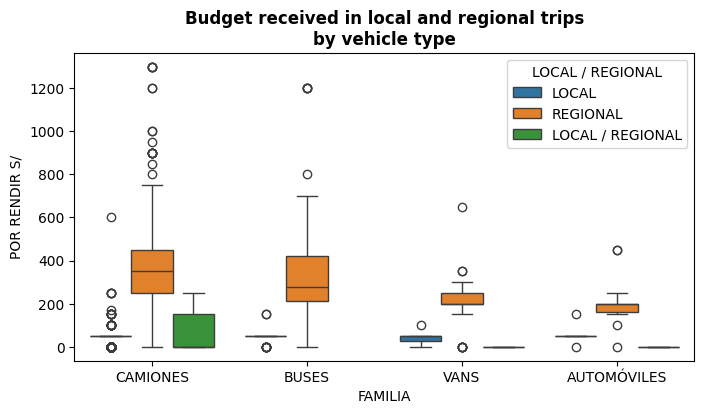

In [155]:
plt.figure(figsize = (8, 4))
(
    budget_table.
    pipe(
        lambda df:
            sns.boxplot(
                data = df, 
                x = 'FAMILIA', 
                y = 'POR RENDIR S/', 
                hue = 'LOCAL / REGIONAL',
                )
    )
)
plt.title("Budget received in local and regional trips\nby vehicle type", fontdict = {'weight': 'bold'})
plt.show()

<div style = 'font-family: Verdana'>
<uL>
    <li>As shown in the box plot, a regional trip receives a higher amount of budget compared to a local trip</li> 
    <li>The local and regional trips of the trucks were combined and that is why we saw a lot of outliers. </li>
    <li>You can see a wider spread in the regional trips. And this could be determined by the distance of the route, which can be measured by the mileage variable.</li>
    <li>It's interesting to see that there are regional trips that gets the same budget of a local trip.</li>
    <li>It makes no sense to see a third value for this variable: LOCAL / REGIONAL. It's not clear why the company decided to include it. What does it mean?</li>
</ul>

<hr>

<p> Let's find out which trips were made by the same vehicle under different conditions (Semi-New and New), to check if there is a difference between the budget that one trip with respect to the other:
</p>
</div>

In [156]:
# SQL way
get_query = lambda query: sqldf(query, globals())

query = f"""
SELECT ROUTE, FAMILIA, COUNT(DISTINCT "NUEVO / SEMINUEVO") AS CONDITIONS
FROM budget_table as BT
GROUP BY ROUTE, FAMILIA
HAVING CONDITIONS = 2
"""

df_both_conditions = get_query(query)
df_both_conditions

,ROUTE,FAMILIA,CONDITIONS
0,CPR - LOCAL CLIENTE,CAMIONES,2
1,LOCAL CLIENTE - MACROPOLIS,BUSES,2
2,SUC. KM24 - SUC. CERRO DE PASCO,CAMIONES,2


<p style = 'font-family: Verdana'>
Well, there are 3 routes that were made by the same vehicle under different conditions. So let's calculate the difference between their budgets.
</p>

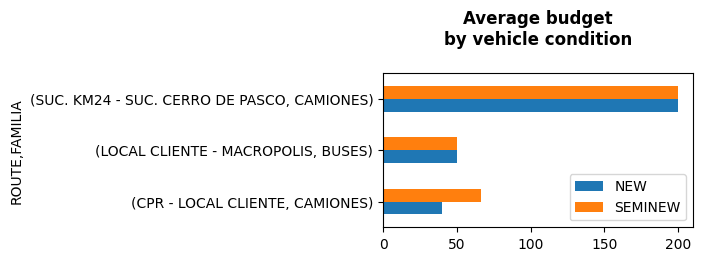

In [157]:
(
    pd.merge(
        left = budget_table,
        right = df_both_conditions,
        on = ['ROUTE', 'FAMILIA'] 
    ).
    pivot_table(
        index = ['ROUTE', 'FAMILIA'],
        columns = ['NUEVO / SEMINUEVO'],
        aggfunc = {'POR RENDIR S/': 'mean'}
    ).
    plot(
        kind = 'barh',
        figsize = (4, 2)
    )
)
plt.legend(['NEW', 'SEMINEW'])
plt.title('Average budget\nby vehicle condition\n', fontdict = {'weight': 'bold'})
plt.show()



<p style = "font-family: Verdana">

The first two routes show us that a used vehicle does not necessarily get more money than a new one.  

<hr>

<h4 style = "text-align: center"><strong>DISTANCE TABLE</strong></h4>

Now, we will analyze whether the distance of a trip is an important variable in determining the amount of budget to be delivered. The Google Distance Matrix API will be used for this task, but it's important to add some information when sending the request to be accurate:
<ul>
    <li>All trips are in Perú. </li>
    <li>Local trips are made within the capital city (i.e Lima).</li>
</ul>
👷🏻‍♂️The creation of the distance table was carried out in `scripts/route_distances/distance_calculator.py`⛏️

Before we proceed with creating the table containing the distances of each route. It's important to make sure that there are not values within the columns "ORIGEN" and "DESTINO" that refer to a same location, but are considered different due to a typo. For this complex task, we will use a NPL model:
</p>

In [158]:
from sentence_transformers import SentenceTransformer, util

model = SentenceTransformer("all-MiniLM-L6-v2")

In [159]:
# First, we make sure that there are no null values within the columns ORIGEN
# and DESTINO. If this is not the case, then it must be checked that all the 
# values are str-objects.
for c in ['ORIGEN', 'DESTINO']:
    column = df_TransportCompany.loc[:, c]
    null_data = column.isnull().sum() 
    if null_data == 0:
        N = len(column)
        str_val = column.apply(lambda val: type(val) == str).sum()
        print(f'{c} -> Str values prop. = {str_val/N} AND null data = 0')

ORIGEN -> Str values prop. = 1.0 AND null data = 0
DESTINO -> Str values prop. = 1.0 AND null data = 0


In [160]:
# It's time to format the values of these columns to avoid problems when
# comparing an upper character to a lower one, or if there's an empty space that
# makes 2 values are not equal.
for c in ['ORIGEN', 'DESTINO']:
    df_TransportCompany[c] = df_TransportCompany[c].str.title().str.strip()

In [161]:
# Store the values:
points = {col: df_TransportCompany.loc[:, col]
          for col in ["ORIGEN", "DESTINO"]}
points = pd.Series(np.union1d(points["ORIGEN"], points["DESTINO"]))
# Convert these values to high-dimentsional vectors (embedding)
embeddings = model.encode(points)
# Find out which values are very similar by using the cosine similarity:
# If the score is close to 1, the vectors are almost parallel. This means these 
# points are syntactically very similar.
scores = util.cos_sim(embeddings, embeddings)

In [162]:
# From the calculated cosine similarity values, we can find the groups of words 
# that are syntactically similar. We say that two words belong to the same group
# if and only if their score is between 0.8 and 1. In this way, we get binary vectors 
bin_groups = set()
for el in np.where(0.8 <= scores, 1, 0):
    if el.sum() > 1:
        bin_groups.add(tuple(el))
# Then, from these binary vectors we can retrieve the groups of words, where each
# 1 in the vector represents a position in the 'points' list that we have created.
# For this task, we created a JSON object where each element stores the words
# that are similar and the correct one that will replace all of those ocurrences.
word_groups = {}
for n, bg in enumerate(bin_groups):
    word_groups[n] = {'words': tuple(points[pd.Series(bg).apply(lambda x: bool(x))]),
                      'correct': None}
del bin_groups

In [163]:
# with open('./notebooks/groups.json', 'w') as f:
#     json.dump(word_groups, f, indent=4)

In [164]:
# Once we set the correct values for each group
with open('./notebooks/groups.json', 'r') as f:
    correct_words = json.load(f)

In [165]:
# Overwrite some values within the columns ORIGEN and DESTINO
for g in correct_words.values():
    for ptype in ['ORIGEN', 'DESTINO']:
        df_TransportCompany.loc[
            df_TransportCompany[ptype].isin(g['words']), ptype
            ] = g['correct']

<p style = "font-family: Verdana">
We need to add more details (province and country) in the addresses of the origin and destination points to receive an accurate answer when sending the request:
</p>

In [166]:
# The local trips were made in the capital of Peru: Lima
local_points = df_TransportCompany.loc[
        df_TransportCompany['LOCAL / REGIONAL'] == 'LOCAL',
        ['ORIGEN', 'DESTINO']
    ].melt().value.drop_duplicates()
for ptype in ['ORIGEN', 'DESTINO']:
    df_TransportCompany.loc[
        df_TransportCompany[ptype].isin(local_points), 
        ptype] = df_TransportCompany.loc[
            df_TransportCompany[ptype].isin(local_points), 
            ptype] + ', Lima, Peru'
# The regional trips have either origin or destination point in Lima. And, the opposite 
# point is located in another province of Peru.
regional_routes = df_TransportCompany[df_TransportCompany['LOCAL / REGIONAL'] == 'REGIONAL'].index
for row in regional_routes:
    origin, destination = df_TransportCompany.loc[row, ['ORIGEN', 'DESTINO']]
    if origin.endswith('Peru') and not destination.endswith('Peru'):
        df_TransportCompany.loc[row, 'DESTINO'] = destination + ', Peru'
    elif not( origin.endswith('Peru') or destination.endswith('Peru') ):
        df_TransportCompany.loc[row, 'ORIGEN'] = origin + ', Peru'
        df_TransportCompany.loc[row, 'DESTINO'] = destination + ', Peru'
    elif not origin.endswith('Peru') and destination.endswith('Peru'):
        df_TransportCompany.loc[row, 'ORIGEN'] = origin + ', Peru'

In [167]:
# (
#     df_TransportCompany.
#     loc[first_cond & second_cond, ['ORIGEN', 'DESTINO', 'POR RENDIR S/']].
#     to_csv('scripts/route_distances/budgets.csv')
# )

[]

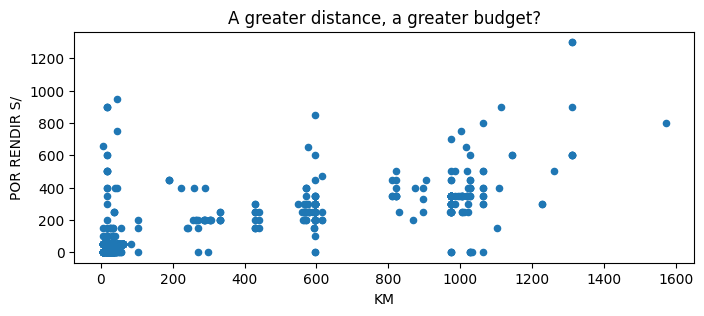

In [176]:
# Once the budget table has been created.
budget_table = pd.read_csv("data/budget_table.csv")
# Let's analyze if it's true that the statement: a greater distance, a greater budget
budget_table.plot(
    kind="scatter",
    x="KM",
    y="POR RENDIR S/",
    figsize=(8, 3),
    title="A greater distance, a greater budget?"
)
plt.plot()

<p style = "font-family: Verdana"> There is a slight upward tendency indicating that a greater distance is associated with the delivery of a greater budget. Howeever, it cannot be stated that this fact is absolutely true, since there are points that don't respect that statement. Therefore, it does not exist a clear behavior.</p>